# HSE 2023: Mathematical Methods for Data Analysis

## Homework 4

### Sharapov Egor BSE219

### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

![](https://memepedia.ru/wp-content/uploads/2022/10/mudroe-tainstvennoe-derevo-mem-25.jpg)

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

Let's implement the function **H()**: 

In [51]:
def H(y: np.array) -> float:
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if np.size(y,) != 0:
        return np.mean(np.abs(y - np.mean(y)))
    else:
        return 0.0

Let's test the function:

In [52]:
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

Now, let's implement the function **Q()**:

In [53]:
def Q(X: np.array, y: np.array, j: int, t: float) -> float:
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    left = X[:, j] < t
    right = X[:, j] >= t
    
    h_left = H(y[left])
    h_right = H(y[right])
    
    return ((len(y[left]) * h_left) + (len(y[right]) * h_right)) / len(y)

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

Now let's create Node calss:

In [54]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self, deep: int = 0, pred: float = 0.0):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = deep
        self.is_terminal = False
        self.prediction = pred
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

Creating MyDecisionTreeRegressor:

In [55]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 

        for j in range(X.shape[1]):
            for t in X[:, j]:
                left = X[:, j] < t
                right = X[:, j] >= t
                
                # Calculate the cost for the split
                now_cost = Q(X, y, j, t)
                
                if now_cost < best_cost:
                    best_cost = now_cost
                    best_split_column = j
                    best_threshold = t
                    X_left = X[left]
                    y_left = y[left]
                    X_right = X[right]
                    y_right = y[right]

        if best_split_column is not None:
            return best_split_column, best_threshold, X_left, y_left, X_right, y_right
        else:
            return None, None, None, None, None, None
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if not self.is_terminal(node, y):
            split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

            if split_column is not None:

                if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:
                    node.is_terminal = True
                    return
            
                node.column = split_column
                node.threshold = threshold

                node.left = Node(pred=np.mean(y_left), deep=node.depth + 1)
                node.right = Node(pred=np.mean(y_right), deep=node.depth + 1)
                
                self.grow_tree(node.left, X_left, y_left)
                self.grow_tree(node.right, X_right, y_right)
                return

        node.is_terminal = True
                

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 1                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)

        self.n_features_in_ = X.shape[1]
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction
        elif x[node.column] < node.threshold:
            return self.get_prediction(node.left, x)
        else:
            return self.get_prediction(node.right, x)
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

Checking myself:

In [56]:
from sklearn.utils.estimator_checks import check_estimator

In [57]:
check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

Let's import tools:

In [58]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

Now, we can make function to print tree:

In [59]:
def print_tree(node: Node, depth: int = 0, prefix: str = "Root | ") -> None:
    """ 
    Function that print tree by each node.
        
    Parameters
    ----------
    node : Node
        Node to start print tree.
    depth : int
        Node depth.
    prefix : str
        Prefix to print
    Returns
    -------
    None
    """
    if node is not None:
        # Print prefix for node + take in count depth by spaces.
        print("  " * depth + prefix, end=" ")

        # Print node itself.
        print(repr(node))

        # Go to the siblings nodes.
        print_tree(node.left, depth + 1, "L->")
        print_tree(node.right, depth + 1, "R->")

And function to plot tree:

In [60]:
def plot_tree(node: Node, depth: int = 0, x_offset: float = 0, y_offset: float = 0, parent_node: Node = None) -> None:
    """ 
    Function that plot tree by each node.
        
    Parameters
    ----------
    node : Node
        Node to start plot tree.
    depth : int
        Node depth.
    x_offset : float
        Offset by x to plot node.
    y_offset : float
        Offset by y to plot node.
    parent_node : Node
        Parant node for this node.
    Returns
    -------
    None
    """
    if node is not None:
        # Plot the node and info about it.
        plt.scatter(x_offset, y_offset, s=200, color='white', edgecolors='black', zorder=100)
        plt.text(x_offset, y_offset - 0.1, str(node), ha='center', va='center', fontsize=7)

        # Take parent node in count.
        if parent_node is not None:
            plt.plot([parent_node[0], x_offset], [parent_node[1], y_offset], color='black')

        # Go to the siblings nodes.
        plot_tree(node.left, depth + 1, x_offset - 2 ** (5 - depth), y_offset - 1, (x_offset, y_offset))
        plot_tree(node.right, depth + 1, x_offset + 2 ** (5 - depth), y_offset - 1, (x_offset, y_offset))


Let's get boston dataset because in this version we do not have it in sklearn.datasets:

In [61]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

Split the data into train and test sets:

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

Define tree with different depths:

In [63]:
depths = [1, 3, 5]
trees = []

In [64]:
for depth in depths:
    tree = MyDecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train, y_train)
    trees.append(tree)

Now we need to output plots and info:

			Depth 1
Depth 1 | MAE on Train: 6.89	MAE on Test: 6.22
Root |  Pred: 22.91


			Depth 3
Depth 3 | MAE on Train: 3.51	MAE on Test: 3.53
Root |  Col 5, t 6.80, Pred: 22.91
  L-> Col 12, t 14.43, Pred: 19.63
    L-> Pred: 22.97
    R-> Pred: 14.95
  R-> Col 5, t 7.45, Pred: 35.37
    L-> Pred: 30.98
    R-> Pred: 44.84


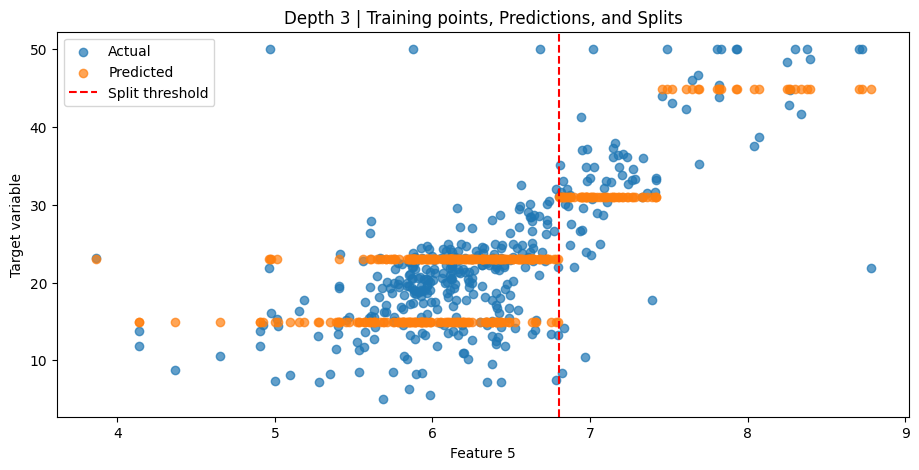

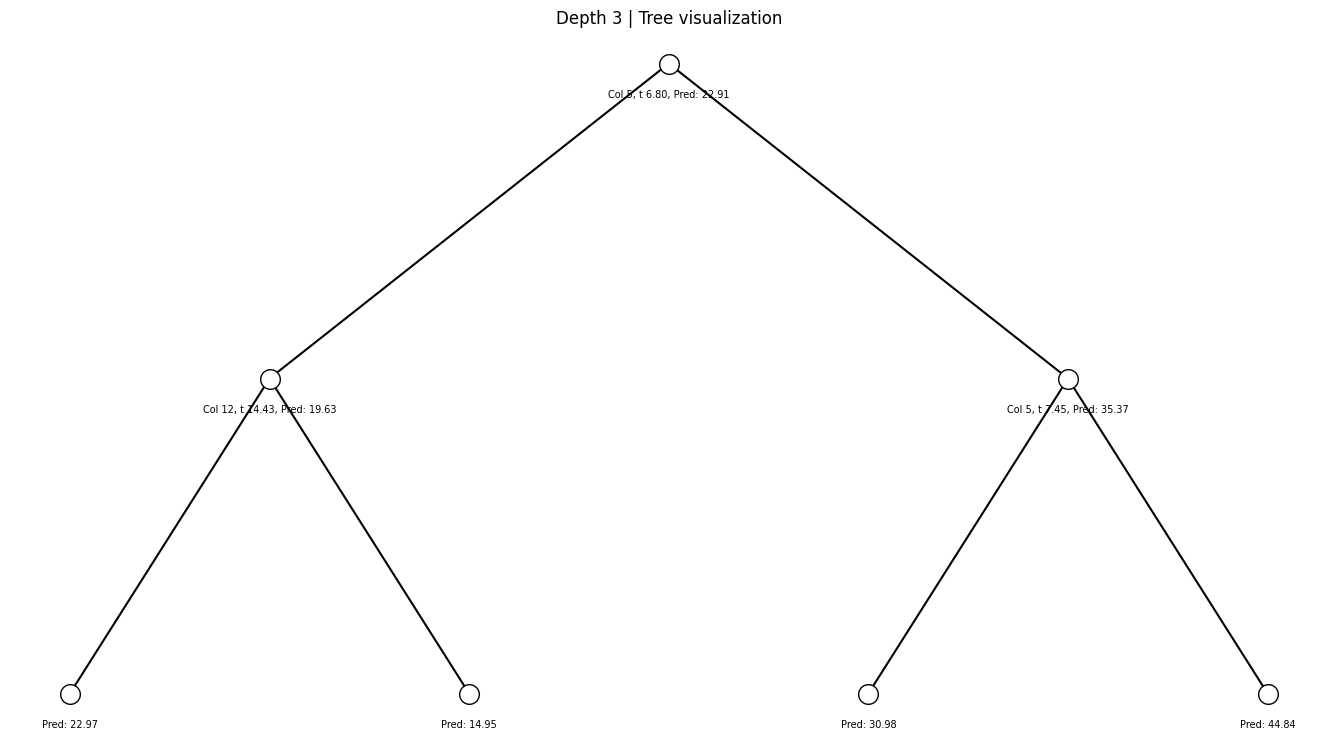

			Depth 5
Depth 5 | MAE on Train: 2.65	MAE on Test: 2.82
Root |  Col 5, t 6.80, Pred: 23.65
  L-> Col 12, t 14.43, Pred: 20.11
    L-> Col 7, t 1.51, Pred: 23.40
      L-> Pred: 50.00
      R-> Col 5, t 6.50, Pred: 22.79
        L-> Pred: 21.88
        R-> Pred: 26.59
    R-> Col 0, t 0.88, Pred: 15.39
      L-> Col 6, t 47.60, Pred: 19.61
        L-> Pred: 23.40
        R-> Pred: 18.94
      R-> Col 0, t 9.92, Pred: 13.36
        L-> Pred: 14.64
        R-> Pred: 10.98
  R-> Col 5, t 7.52, Pred: 36.91
    L-> Col 0, t 8.25, Pred: 32.12
      L-> Col 2, t 19.58, Pred: 33.63
        L-> Pred: 33.13
        R-> Pred: 41.30
      R-> Col 0, t 11.81, Pred: 13.60
        L-> Pred: 17.80
        R-> Pred: 9.40
    R-> Col 0, t 0.58, Pred: 46.32
      L-> Col 6, t 24.80, Pred: 45.27
        L-> Pred: 42.50
        R-> Pred: 46.14
      R-> Pred: 50.00


In [177]:
for i, depth in enumerate(depths):
    # Print info.
    print(f"\t\t\tDepth {depth}")
    
    # MAE on train and test.
    y_train_pred = trees[i].predict(X_train)
    y_test_pred = trees[i].predict(X_test)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Print tree.
    print(f"Depth {depth} | MAE on Train: {mae_train:.2f}\tMAE on Test: {mae_test:.2f}")
    print_tree(trees[i].tree_)

    # Plot Training points.
    plt.figure
    if trees[i].tree_.column is not None:
        plt.scatter(X_train[:, trees[i].tree_.column], y_train, label="Actual", alpha=0.7)
        
        # Plot predictions
        plt.scatter(X_train[:, trees[i].tree_.column], y_train_pred, label="Predicted", alpha=0.7)

        # Plot splits
        plt.axvline(x=trees[i].tree_.threshold, color='red', linestyle='--', label='Split threshold')
        
        plt.title(f"Depth {depth} | Training points, Predictions, and Splits")
        plt.xlabel(f"Feature {trees[i].tree_.column}")
        plt.ylabel("Target variable")
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No split made in the tree", horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')

    # Visualize tree.
    plt.figure(figsize=(17, 9))
    plot_tree(trees[i].tree_)
    plt.title(f"Depth {depth} | Tree visualization")
    plt.axis('off')
    
    plt.show()

**Comment**

Yes, we can see overfitting on second and third tree but not on first tree with depth 1. 

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

Let's import tools:

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

Creating params:

In [71]:
param = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

Create GridSearchCV:

In [72]:
grid_search = GridSearchCV(MyDecisionTreeRegressor(), param, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MyDecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 4, 6]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

Training the model with the best set of hyperparameters on the whole train dataset.

In [73]:
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)

MyDecisionTreeRegressor(max_depth=7, min_samples_leaf=2)

Output MAE and hyperparameters of the best estimator:

In [75]:
print(f"MAE on Test: {mean_absolute_error(y_test, best_tree.predict(X_test)):.4f}")
print(f"Best Hyperparameters: {grid_search.best_params_}")

MAE on Test: 2.6450
Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 2}


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [125]:
# Hide warnings.
import warnings
warnings.filterwarnings("ignore")

In [178]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    set_nums = set([num for num in range(x.shape[0])])
    bias_mean = 0.0
    varience_mean = 0.0
    
    predictions = {
        'bias': list(),
        'variance': list()
    }
    
    for _ in range(n_iter):
        
        indices = np.random.choice(list(set_nums), size=x.shape[0], replace=True)
        
        x_bootstrap = x[indices, :]
        y_bootstrap = y[indices]

        indices = np.random.choice(list(set_nums - set(indices)), replace=True, size=x.shape[0])
        
        estimator.fit(x_bootstrap, y_bootstrap)

        predictions['bias'].append(np.mean((y[indices] - np.mean(estimator.predict(x[indices, :])))**2))
        predictions['variance'].append(np.mean(np.var(estimator.predict(x[indices, :]))))
        bias_mean = np.mean(predictions['bias'])
        varience_mean = np.mean(predictions['variance'])
    
    return bias_mean, varience_mean

Let's test:

In [179]:
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

np.random.seed(123)
get_bias_variance(estimator, X_train, y_train, 10)

(91.00386877560757, 79.16177072453401)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

In [172]:
min_samples = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200, 300]

In [173]:
biases = []
variances = []

Let's iterate over min_samples_split values to get biases and variances:

In [174]:
for min_samples_split in min_samples:
    #np.random.seed(123)
    bias, variance = get_bias_variance(MyDecisionTreeRegressor(min_samples_split=min_samples_split), X_train, y_train, n_iter=10)

    biases.append(bias)
    variances.append(variance)

Now we need to plot resaults:

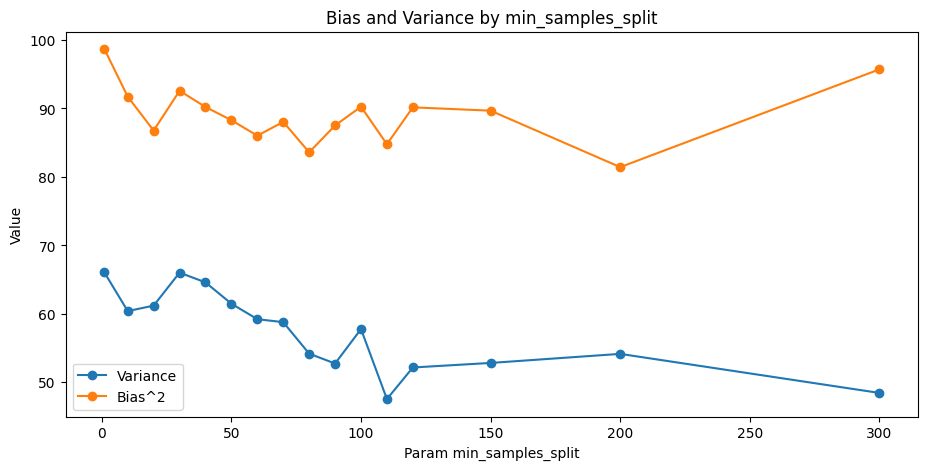

In [175]:
plt.figure
plt.plot(min_samples, variances, label='Variance', marker='o')
plt.plot(min_samples, biases, label='Bias^2', marker='o')
plt.title('Bias and Variance by min_samples_split')
plt.xlabel('Param min_samples_split')
plt.ylabel('Value')
plt.legend()
plt.show()

**Comment**

Increasing *'min_samples_split'* leads to a decrease in model complexity, which result in little bit higher bias but lower variance. 

The bias-variance trade-off suggests that there is an optimal point where the sum of bias squared and variance is minimized.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

Now we need to import BaggingRegressor:

In [149]:
from sklearn.ensemble import BaggingRegressor

Let's create BaggingRegressor:

In [150]:
bagging_model = BaggingRegressor(base_estimator=MyDecisionTreeRegressor(), n_estimators=10, random_state=42)

Get and output data:

In [151]:
np.random.seed(123)
bias_bagging, variance_bagging = get_bias_variance(bagging_model, X_train, y_train, n_iter=10)

In [152]:
np.random.seed(123)
bias_tree, variance_tree = get_bias_variance(tree, X_train, y_train, n_iter=10)

In [153]:
print(f"Individual tree | Bias: {bias_tree}\tVariance: {variance_tree}")
print(f"Bagging tree    | Bias: {bias_bagging}\tVariance: {variance_bagging}")

Individual tree | Bias: 91.08890157170188	Variance: 73.71742553760811
Bagging tree    | Bias: 91.1032704868058	Variance: 57.891648168809766


**Comment**

**Bagging: Bias and variance in theory**

Bagging do not significantly impact bias because it involves training multiple models on different samples.
The average of these models tends to retain the same bias as individual model.
Bagging reduce variance by averaging over multiple models. 
Ensemble's averaging process can smooth out extreme predictions, leading to a more stable and robust model.

**Comparation: Bias and variance**

Bias of the bagging model remains aprox similar to an individual tree. 
Variance is lower in the bagging model.

**Align with the theory**

The results align with the theory. The theory works and is implemented in code.

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task. 

In [102]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
df.head(5)

rank  finalWorth               category                personName   age  \
0     1      211000       Fashion & Retail  Bernard Arnault & family  74.0   
1     2      180000             Automotive                 Elon Musk  51.0   
2     3      114000             Technology                Jeff Bezos  59.0   
3     4      107000             Technology             Larry Ellison  78.0   
4     5      106000  Finance & Investments            Warren Buffett  92.0   

         country    city              source             industries  \
0         France   Paris                LVMH       Fashion & Retail   
1  United States  Austin       Tesla, SpaceX             Automotive   
2  United States  Medina              Amazon             Technology   
3  United States   Lanai              Oracle             Technology   
4  United States   Omaha  Berkshire Hathaway  Finance & Investments   

  countryOfCitizenship  ... cpi_change_country           gdp_country  \
0               France  ...                1.1   $2,715,518,274,227    
1        United States  ...                7.5  $21,427,700,000,000    
2        United States  ...                7.5  $21,427,700,000,000    
3        United States  ...                7.5  $21,427,700,000,000    
4        United States  ...                7.5  $21,427,700,000,000    

  gross_tertiary_education_enrollment  \
0                                65.6   
1                                88.2   
2                                88.2   
3                                88.2   
4                                88.2   

  gross_primary_education_enrollment_country life_expectancy_country  \
0                                      102.5                    82.5   
1                                      101.8                    78.5   
2                                      101.8                    78.5   
3                                      101.8                    78.5   
4                                      101.8                    78.5   

  tax_revenue_country_country total_tax_rate_country population_country  \
0                        24.2                   60.7         67059887.0   
1                         9.6                   36.6        328239523.0   
2                         9.6                   36.6        328239523.0   
3                         9.6                   36.6        328239523.0   
4                         9.6                   36.6        328239523.0   

  latitude_country longitude_country  
0        46.227638          2.213749  
1        37.090240        -95.712891  
2        37.090240        -95.712891  
3        37.090240        -95.712891  
4        37.090240        -95.712891  

[5 rows x 35 columns]

### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

Let's import tools:

In [103]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

**In this case I prefer 'not to fill' method of fill missing values.**

Drop rows with not enough data:

In [104]:
threshold = 0.8
df = df.dropna(thresh=threshold*len(df), axis=1)

Let's split the dataset into train and test sets:

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('selfMade', axis=1),
    le.fit_transform(df['selfMade']),
    test_size=0.2,
    random_state=42
)

Now, we need to find categorical and numeric features:

In [106]:
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(include=['number']).columns

Let's create transformer:

In [107]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

In [108]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

In [109]:
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_cols),
        ('numeric', numeric_transformer, numeric_cols)
    ],
    remainder='passthrough'
)

Transform the data:

In [110]:
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

Let's import tools:

In [192]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

Now we need to create models dict:

In [193]:
models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(class_weight="balanced"),
    'Decision Tree': DecisionTreeClassifier(class_weight="balanced"),
    'SVM': SVC(class_weight="balanced", max_iter=5000),
    'Logistic Regression': LogisticRegression(class_weight="balanced", max_iter=5000)
}
scores = {'Model': [], 'Training': [], 'Test': []}

Let's make scorer for cros validation:

In [194]:
scorer = make_scorer(f1_score)

Let's compare models using cross-validation:

In [195]:
for name, model in models.items():
    cv_scores = cross_validate(model, X_train, y_train, cv=5, scoring=scorer, return_estimator=True)
    model = cv_scores['estimator'][np.argmax(cv_scores["test_score"])]
    models[name] = model.fit(X_train, y_train)
    
    train = f1_score(y_train, model.predict(X_train))
    
    test = f1_score(y_test, model.predict(X_test))
    
    scores['Model'].append(name)
    scores['Training'].append(train_f1)
    scores['Test'].append(test_f1)
    
    print(f'Model: {name} | Training F1: {train:.4f}\tTest F1: {test:.4f}')

Model: Gradient Boosting | Training F1: 0.9005	Test F1: 0.8728
Model: Random Forest | Training F1: 1.0000	Test F1: 0.8838
Model: Decision Tree | Training F1: 1.0000	Test F1: 0.8324
Model: SVM | Training F1: 0.9354	Test F1: 0.8288
Model: Logistic Regression | Training F1: 0.9917	Test F1: 0.8717


Output best model and data about overfitting of models:

In [196]:
print(f"Best Model: {scores['Model'][np.argmax(scores['Test'])]} | Test F1: {scores['Test'][np.argmax(scores['Test'])]:.4f}")

for i in range(len(models)):
    if scores['Training'][i] > scores['Test'][i]:
        print(f'{scores["Model"][i]} is overfitting.')
    elif scores['Training'][i] < scores['Test'][i]:
        print(f'{scores["Model"][i]} is underfitting.')
    else:
        print(f'{scores["Model"][i]} has a balanced fit.')

Best Model: Gradient Boosting | Test F1: 0.8732
Gradient Boosting is overfitting.
Random Forest is overfitting.
Decision Tree is overfitting.
SVM is overfitting.
Logistic Regression is overfitting.


**Comment**

**Some question answers in output above**

The F1 score is a metric that combines precision and recall into a single value, providing a good measure of a classifier's performance. 
F1 score is a versatile metric that work good in various real-world applications.

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

Get instruments for task:

In [168]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBClassifier

Let's get model and create params dict:

In [179]:
xgb_model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

Now let's select best params on cross_validate:

In [180]:
cv_scores = cross_validate(GridSearchCV(xgb_model, param_grid, cv=5, scoring=scorer, n_jobs=-1), X_train, y_train, cv=5, scoring=scorer, return_estimator=True, n_jobs=-1)
best_xgb_model = cv_scores['estimator'][np.argmax(cv_scores["test_score"])]

Fit the best model:

In [181]:
best_xgb_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(f1_score))

Get score:

In [182]:
val_f1 = f1_score(y_test, best_xgb_model.predict(X_test))
print(f'XGBoost [Best Hyperparameters] - Test F1: {val_f1:.4f}')

XGBoost [Best Hyperparameters] - Test F1: 0.8818


**Comment**

This model turns out to be better than all the previous models, the reason being the qualitative selection of hyperparameters which brought the model to a high F1 score.

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

Import tools:

In [197]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier

Creating models dict:

In [198]:
models = {
    'Bagging with Decision Trees': [BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42), 'Bagging'],
    'Bagging with Gradient Boosting': [BaggingClassifier(base_estimator=GradientBoostingClassifier(n_estimators=200, random_state=42), n_estimators=50, random_state=42), 'Bagging'],
    'Voting Classifier': [VotingClassifier(estimators=[
        ('decision_tree', DecisionTreeClassifier(random_state=42)),
        ('gradient_boosting', GradientBoostingClassifier(n_estimators=200, random_state=42)),
        ('logistic_regression', LogisticRegression(max_iter=10000, random_state=42))
    ], voting='hard'), 'Voting'],
    'Stacking with Logistic Regression': [StackingClassifier(estimators=[
        ('decision_tree', DecisionTreeClassifier(random_state=42)),
        ('gradient_boosting', GradientBoostingClassifier(n_estimators=200, random_state=42)),
    ], final_estimator=LogisticRegression(max_iter=10000, random_state=42)), 'Stacking'],
    'Stacking with Gradient Boosting': [StackingClassifier(estimators=[
        ('decision_tree', DecisionTreeClassifier(random_state=42)),
        ('gradient_boosting', GradientBoostingClassifier(n_estimators=200, random_state=42)),
    ], final_estimator=GradientBoostingClassifier(n_estimators=200, random_state=42)), 'Stacking']
}
scores_s = {'ModelName': [], 'Training': [], 'Test': []}

Let's get scores:

In [199]:
for name, [model, model_type] in models_b.items():
    model.fit(X_train, y_train)
    train_f1 = f1_score(y_train, model.predict(X_train))
    test_f1 = f1_score(y_test, model.predict(X_test))
    
    scores_s['ModelName'].append(name)
    scores_s['Training'].append(train_f1)
    scores_s['Test'].append(test_f1)
    
    print(f'Model: {name} ({model_type}) | Training F1: {train_f1:.4f}\tTest F1: {test_f1:.4f}')

Model: Bagging with Decision Trees (Bagging) | Training F1: 0.9997	Test F1: 0.8768
Model: Bagging with Gradient Boosting (Bagging) | Training F1: 0.8973	Test F1: 0.8750
Model: Voting Classifier (Voting) | Training F1: 0.9938	Test F1: 0.8758
Model: Stacking with Logistic Regression (Stacking) | Training F1: 0.9304	Test F1: 0.8790
Model: Stacking with Gradient Boosting (Stacking) | Training F1: 0.9176	Test F1: 0.8732


Find model that has the best performance:

In [203]:
best_model_idx = np.argmax(scores_s['Test'])
best_model_name = scores_s['ModelName'][best_model_idx]

print(f'Best Performing Model: {best_model_name} | Test F1: {scores_s["Test"][best_model_idx]:.4f}')

Best Performing Model: Stacking with Logistic Regression | Test F1: 0.8790


Get scores:

In [230]:
score_default = {'Test': scores['Test'][scores['Model'].index('Gradient Boosting')],
                 'Training': scores['Training'][scores['Model'].index('Gradient Boosting')],
                 'Name': "Gradient Boosting",
                 'Delta': 0.0
                }

score_bagging = {'Test': scores_s['Test'][scores_s['ModelName'].index('Bagging with Gradient Boosting')],
                 'Training': scores_s['Training'][scores_s['ModelName'].index('Bagging with Gradient Boosting')],
                 'Name': "Bagging with Gradient Boosting",
                 'Delta': 0.0
                }

In [234]:
print(f"Bagging with Gradient Boosting | Training F1: {score_bagging['Training']:.4f}\tTest F1: {score_bagging['Test']:.4f}")

if score_bagging['Training'] > score_bagging['Test']:
    print(f"{score_bagging['Name']} is overfitting by {score_bagging['Training'] - score_bagging['Test']:.4f}.")
    score_bagging['Delta'] = score_bagging['Training'] - score_bagging['Test']
elif score_bagging['Training'] < score_bagging['Test']:
    print(f"{score_bagging['Name']} is underfitting by {score_bagging['Test'] - score_bagging['Training']:.4f}.")
    score_bagging['Delta'] = -(score_bagging['Test'] - score_bagging['Training'])
else:
    print(f"{score_bagging['Name']} has a balanced fit.")

Bagging with Gradient Boosting | Training F1: 0.8973	Test F1: 0.8750
Bagging with Gradient Boosting is overfitting by 0.0223.


In [235]:
print(f"Gradient Boosting | Training F1: {score_default['Training']:.4f}\tTest F1: {score_default['Test']:.4f}")

if score_default['Training'] > score_default['Test']:
    print(f"{score_default['Name']} is overfitting by {score_default['Training'] - score_default['Test']:.4f}.")
    score_default['Delta'] = score_default['Training'] - score_default['Test']
elif score_default['Training'] < score_default['Test']:
    print(f"{score_default['Name']} is underfitting by {score_default['Test'] - score_default['Training']:.4f}.")
    score_default['Delta'] = -(score_default['Test'] - score_default['Training'])
else:
    print(f"{score_default['Name']} has a balanced fit.")

Gradient Boosting | Training F1: 0.9176	Test F1: 0.8732
Gradient Boosting is overfitting by 0.0444.


Find if bagging reduce overfiting of the gradient boosting with large amount of trees:

In [236]:
if score_default['Delta'] > score_bagging['Delta']:
    print(f"Model: {score_bagging['Name']} reduced overfiting of the gradient boosting!")
elif score_default['Delta'] <= score_bagging['Delta']:
    print(f"Model: {score_bagging['Name']} do NOT reduced overfiting of the gradient boosting(")

Model: Bagging with Gradient Boosting reduced overfiting of the gradient boosting!


**Comment**

**Some question answers in output above**

Voting combines the predictions of multiple models by majority voting (hard voting) or weighted voting (soft voting) in the same time  Stackint uses multiple models as base estimators and combines their predictions using another model, known as the final.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [211]:
print(f'XGBoost [Best Hyperparameters] | Test F1: {val_f1:.4f}')

XGBoost [Best Hyperparameters] | Test F1: 0.8818
